<a href="https://colab.research.google.com/github/nicoRomeroCuruchet/DynamicProgramming/blob/main/testing_bary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pickle
import airplane
import numpy as np
import gymnasium as gym
from utils.utils import test_enviroment
from PolicyIteration import PolicyIteration

glider = gym.make('ReducedBankedGliderPullout-v0')

bins_space = {
    "flight_path_angle": np.linspace(np.deg2rad(-90), np.deg2rad(0),    37,      dtype=np.float32),     # Flight Path Angle (γ)    (0)
    "airspeed_norm":     np.linspace(0.7, 4.0,                          32,      dtype=np.float32),    # Air Speed          (V)    (1)
    "bank_angle":        np.linspace( np.deg2rad(-20), np.deg2rad(200), 45,      dtype=np.float32),    # Bank Angle         (mu)   (2)
}

action_space= np.array(np.meshgrid(np.linspace(-0.5, 1.0, 8, dtype=np.float32), 
                                   np.linspace(np.deg2rad(-30), np.deg2rad(30), 8, dtype=np.float32))).T.reshape(-1, 2)

pi = PolicyIteration(
    env=glider, 
    bins_space=bins_space,
    action_space= action_space,
    gamma=0.99,
    theta=1e-3,
)


pi.run()

2025-02-20 14:12:34.348 | INFO     | PolicyIteration:__init__:129 - Lower bounds: [-1.5707964   0.7        -0.34906584]
2025-02-20 14:12:34.350 | INFO     | PolicyIteration:__init__:130 - Upper bounds: [0.        4.        3.4906585]
2025-02-20 14:12:34.352 | INFO     | PolicyIteration:__init__:149 - Number of states: 53280
2025-02-20 14:12:34.352 | INFO     | PolicyIteration:__init__:150 - Total states:3409920
2025-02-20 14:12:34.357 | INFO     | PolicyIteration:__init__:163 - Policy Iteration was correctly initialized.
2025-02-20 14:12:34.358 | INFO     | PolicyIteration:__init__:164 - The enviroment name is: TimeLimit
2025-02-20 14:12:34.358 | INFO     | PolicyIteration:run:387 - Creating Delaunay triangulation over the state space...
2025-02-20 14:12:37.635 | INFO     | PolicyIteration:run:389 - Delaunay triangulation created.
2025-02-20 14:12:37.635 | INFO     | PolicyIteration:run:399 - Generating transition and reward function table...
c:\Users\nicor\anaconda3\envs\DynamicProgra

In [ ]:
import numpy as np

# Define the range and increment for CL_cmd
lower_bound = -0.5
upper_bound = 1.0
increment = 0.25

# Generate the CL_cmd grid
cl_cmd_grid = np.arange(lower_bound, upper_bound + increment, increment)

# Print the CL_cmd grid
print(cl_cmd_grid)

c:\Users\nicor\anaconda3\envs\DynamicProgramming\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.airplane to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.airplane` for environment variables or `env.get_wrapper_attr('airplane')` that will search the reminding wrappers.
  logger.warn(


Action: [-0.5    0.524] | Reward: -0.0021046393959270973 |             State: (-10.098072052001953, 1.2003628015518188, 160.3000030517578) | Terminated: False |            Episode Length: 0.01
Action: [-0.5    0.524] | Reward: -0.004230103463645236 |             State: (-10.195886611938477, 1.2007315158843994, 160.59999084472656) | Terminated: False |            Episode Length: 0.02
Action: [-0.5    0.524] | Reward: -0.006376355887577156 |             State: (-10.293444633483887, 1.201106071472168, 160.89999389648438) | Terminated: False |            Episode Length: 0.03
Action: [-0.5    0.524] | Reward: -0.008543360629319104 |             State: (-10.390746116638184, 1.201486587524414, 161.1999969482422) | Terminated: False |            Episode Length: 0.04
Action: [-0.5    0.524] | Reward: -0.010731081928269421 |             State: (-10.487792015075684, 1.2018728256225586, 161.49998474121094) | Terminated: False |            Episode Length: 0.05
Action: [-0.5    0.524] | Reward: -0.0

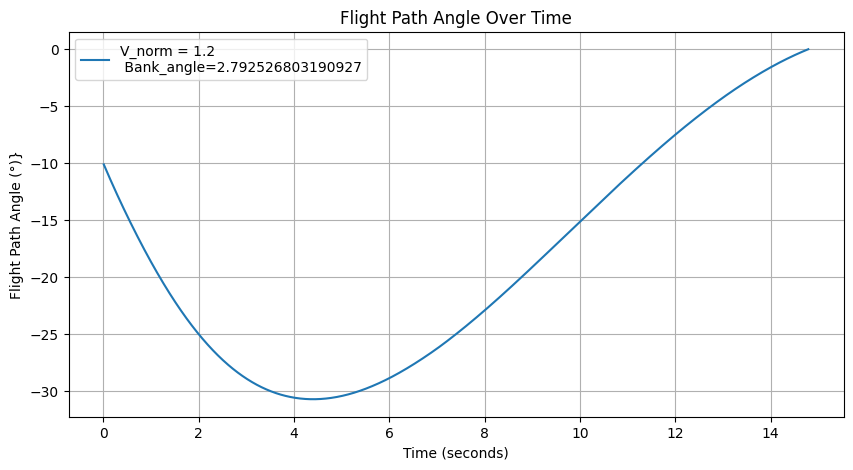

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_optimal_action

initial_state = np.array([np.deg2rad(-10), 1.2, np.deg2rad(160)])
state = initial_state
glider.airplane.flight_path_angle = initial_state[0]
glider.airplane.airspeed_norm     = initial_state[1]
glider.airplane.bank_angle        = initial_state[2]

total_heigh_lost   = 0
episode_length = 0
terminated     = False

# Initialize lists to store data for plotting
flight_path_angles = []
time_steps = []



while episode_length <15:
    action = get_optimal_action(state, pi)
    prev_state  = state.copy()
    state, reward, terminated, _, _ = glider.step(action)
    state = state[0]
    total_heigh_lost += reward
    episode_length += 0.01
    flight_path_angle = float(np.rad2deg(state[0]))
    airspeed_norm     = float(state[1])
    bank_angle        = float(np.rad2deg(state[2]))

        # Store values for plotting
    flight_path_angles.append(flight_path_angle)
    time_steps.append(episode_length)

    print(f"Action: {np.round(action,3)} | Reward: {total_heigh_lost} | \
            State: {flight_path_angle, airspeed_norm, bank_angle} | Terminated: {terminated} |\
            Episode Length: {episode_length}")
    if terminated: break

# Plot Flight Path Angle Over Time
plt.figure(figsize=(10,5))
plt.plot(time_steps, flight_path_angles)
plt.xlabel("Time (seconds)")
plt.ylabel("Flight Path Angle (°)}")
plt.title("Flight Path Angle Over Time")
plt.legend([f"V_norm = {float(initial_state[1])}\n Bank_angle={float(initial_state[2])}"])
plt.grid()
plt.show()
        

Action: [1.    0.075] | Reward: -0.0018814541172693117 |                 State: (-9.01882266998291, 1.2002211809158325, 1.2428570985794067) | Terminated: False |                Episode Length: 0.01 | C_L: 1.0
Action: [1.    0.075] | Reward: -0.003767138116011847 |                 State: (-9.037582397460938, 1.2004433870315552, 1.2857141494750977) | Terminated: False |                Episode Length: 0.02 | C_L: 1.0
Action: [1.    0.075] | Reward: -0.005657041303605611 |                 State: (-9.0562744140625, 1.2006666660308838, 1.3285714387893677) | Terminated: False |                Episode Length: 0.03 | C_L: 1.0
Action: [1.    0.075] | Reward: -0.007551152950322069 |                 State: (-9.074902534484863, 1.2008910179138184, 1.3714284896850586) | Terminated: False |                Episode Length: 0.04 | C_L: 1.0
Action: [1.    0.075] | Reward: -0.009449462289528879 |                 State: (-9.093462944030762, 1.2011163234710693, 1.414285659790039) | Terminated: False |      

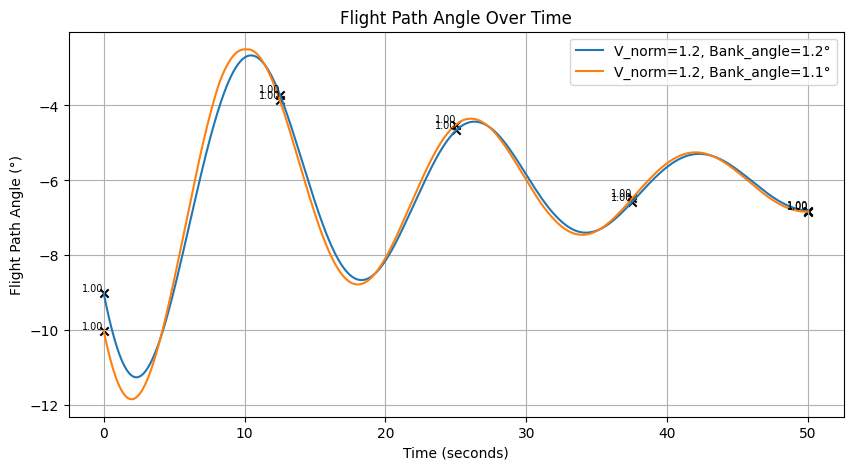

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_optimal_action

# Define multiple initial states (each row is [flight_path_angle, V_norm, bank_angle])
initial_states = [
    [np.deg2rad(-9), 1.2, np.deg2rad(1.2)],
     [np.deg2rad(-10), 1.2, np.deg2rad(1.1)],
    #[np.deg2rad(-13), 1.2, np.deg2rad(90)],
    #[np.deg2rad(-17), 1.0, np.deg2rad(140)],
    #[np.deg2rad(-20), 0.8, np.deg2rad(180)]
]

plt.figure(figsize=(10, 5))  # Initialize plot

# Loop through each initial state
for initial_state in initial_states:
    state = np.array(initial_state)  # Convert list to numpy array
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    glider.airplane.bank_angle = state[2]

    # Storage for plotting
    flight_path_angles = []
    time_steps = []
    cl_values = []
    
    total_heigh_lost = 0
    episode_length = 0
    terminated = False

    # Run simulation
    while episode_length < 50:
        action = get_optimal_action(state, pi)
        prev_state = state.copy()
        state, reward, terminated, _, _ = glider.step(action)
        state = state[0]

        total_heigh_lost += reward
        episode_length += 0.01

        # Convert to readable format
        flight_path_angle = float(np.rad2deg(state[0]))
        V_norm = float(state[1])
        bank_angle = float(np.rad2deg(state[2]))
        C_L = float(action[0])  # Extract lift coefficient

        # Store values
        flight_path_angles.append(flight_path_angle)
        time_steps.append(episode_length)
        cl_values.append(C_L)

        print(f"Action: {np.round(action,3)} | Reward: {total_heigh_lost} | \
                State: {flight_path_angle, V_norm, bank_angle} | Terminated: {terminated} |\
                Episode Length: {episode_length} | C_L: {C_L}")

        if terminated:
            break

    # Plot the curve
    plt.plot(time_steps, flight_path_angles, label=f"V_norm={round(initial_state[1],2)}, Bank_angle={round(np.rad2deg(initial_state[2]),1)}°")

    # Select 10 evenly spaced indices for C_L annotations
    num_points = 5
    if len(time_steps) > num_points:
        indices = np.linspace(0, len(time_steps) - 1, num_points, dtype=int)
    else:
        indices = range(len(time_steps))  # If less than 10 points exist

    # Plot markers and add annotations
    for i in indices:
        plt.scatter(time_steps[i], flight_path_angles[i], color="black", marker="x")  # Mark point
        plt.text(time_steps[i], flight_path_angles[i], f"{cl_values[i]:.2f}", fontsize=7, verticalalignment='bottom', horizontalalignment='right')

# Graph settings
plt.xlabel("Time (seconds)")
plt.ylabel("Flight Path Angle (°)")
plt.title("Flight Path Angle Over Time")
plt.legend()  # Automatically handles multiple curves
plt.grid()
plt.show()


Action: [-0.5    0.524] | Reward: -0.0021046393959270973 |                 State: (-10.098072052001953, 1.2003628015518188, 160.3000030517578) | Terminated: False |                Episode Length: 0.01
Action: [-0.5    0.524] | Reward: -0.004230103463645236 |                 State: (-10.195886611938477, 1.2007315158843994, 160.59999084472656) | Terminated: False |                Episode Length: 0.02
Action: [-0.5    0.524] | Reward: -0.006376355887577156 |                 State: (-10.293444633483887, 1.201106071472168, 160.89999389648438) | Terminated: False |                Episode Length: 0.03
Action: [-0.5    0.524] | Reward: -0.008543360629319104 |                 State: (-10.390746116638184, 1.201486587524414, 161.1999969482422) | Terminated: False |                Episode Length: 0.04
Action: [-0.5    0.524] | Reward: -0.010731081928269421 |                 State: (-10.487792015075684, 1.2018728256225586, 161.49998474121094) | Terminated: False |                Episode Length: 0.0

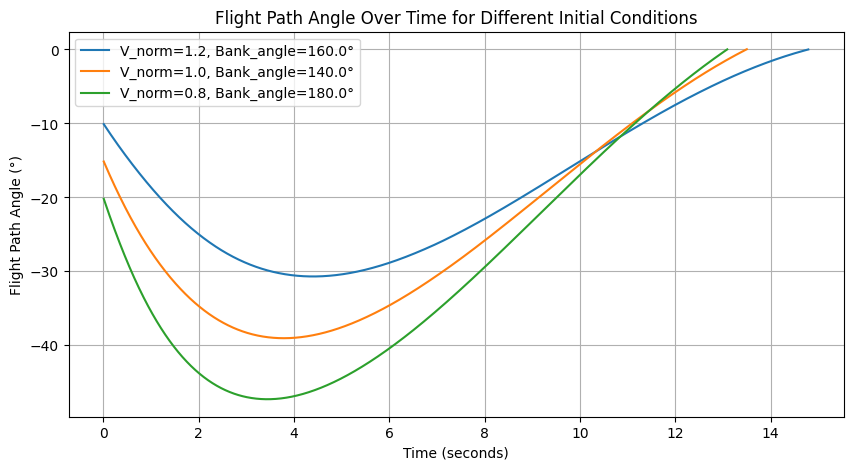

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_optimal_action

# Define multiple initial states (each row is [flight_path_angle, V_norm, bank_angle])
initial_states = [
    [np.deg2rad(-10), 1.2, np.deg2rad(160)],
    [np.deg2rad(-15), 1.0, np.deg2rad(140)],
    [np.deg2rad(-20), 0.8, np.deg2rad(180)]
]

plt.figure(figsize=(10, 5))  # Initialize plot

# Loop through each initial state
for initial_state in initial_states:
    state = np.array(initial_state)  # Convert list to numpy array
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    glider.airplane.bank_angle = state[2]

    # Storage for plotting
    flight_path_angles = []
    time_steps = []

    total_heigh_lost = 0
    episode_length = 0
    terminated = False

    # Run simulation
    while episode_length < 15:
        action = get_optimal_action(state, pi)
        prev_state = state.copy()
        state, reward, terminated, _, _ = glider.step(action)
        state = state[0]

        total_heigh_lost += reward
        episode_length += 0.01

        # Convert to readable format
        flight_path_angle = float(np.rad2deg(state[0]))
        V_norm = float(state[1])
        bank_angle = float(np.rad2deg(state[2]))

        # Store values
        flight_path_angles.append(flight_path_angle)
        time_steps.append(episode_length)

        print(f"Action: {np.round(action,3)} | Reward: {total_heigh_lost} | \
                State: {flight_path_angle, V_norm, bank_angle} | Terminated: {terminated} |\
                Episode Length: {episode_length}")

        if terminated:
            break

    # Plot for this initial condition
    plt.plot(time_steps, flight_path_angles, label=f"V_norm={round(initial_state[1],2)}, Bank_angle={round(np.rad2deg(initial_state[2]),1)}°")

# Graph settings
plt.xlabel("Time (seconds)")
plt.ylabel("Flight Path Angle (°)")
plt.title("Flight Path Angle Over Time for Different Initial Conditions")
plt.legend()  # Automatically handles multiple curves
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

print(pi.bins_space["airspeed_norm"])


# Example discretization
flight_path_bins = pi.bins_space["flight_path_angle"]   # Flight Path Angle (deg)
bank_bins        = pi.bins_space["bank_angle"]  # Bank Angle (deg)

# Prepare a 2D array to store the policy (CL values)
policy_values = np.zeros((len(flight_path_bins), len(bank_bins)))

# Fill in the 2D array by evaluating your policy at each (γ, μ)
for i, gamma_deg in enumerate(flight_path_bins):
    for j, mu_deg in enumerate(bank_bins):
        # Convert angles to radians if your policy needs it
        state = (np.deg2rad(gamma_deg),  1.2322581, np.deg2rad(mu_deg))
        action = get_optimal_action(state, pi)  # Replace with your actual policy call
        cl = action[1]  # If the first element of `action` is the lift coefficient
        policy_values[i, j] = cl

[0.7        0.8064516  0.91290325 1.0193548  1.1258065  1.2322581
 1.3387097  1.4451613  1.5516129  1.6580645  1.7645161  1.8709677
 1.9774194  2.083871   2.1903226  2.2967741  2.403226   2.5096774
 2.616129   2.7225807  2.8290322  2.935484   3.0419354  3.1483872
 3.2548387  3.3612902  3.467742   3.5741935  3.6806452  3.7870967
 3.8935485  4.        ]


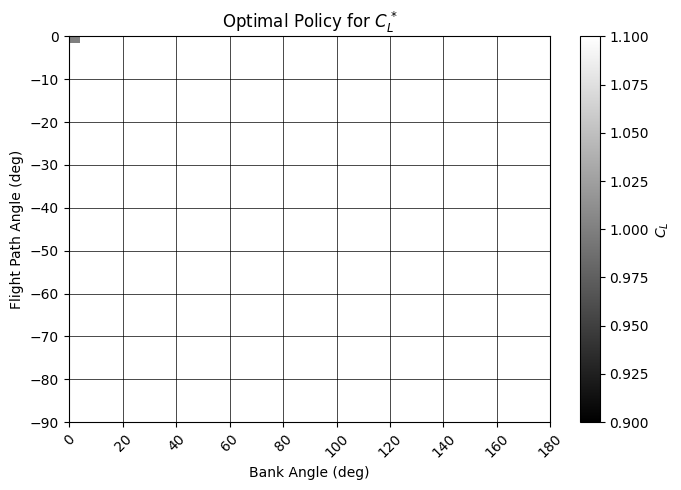

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Define the bins
# Example discretization
flight_path_bins = pi.bins_space["flight_path_angle"]   # Flight Path Angle (deg)
bank_bins        = pi.bins_space["bank_angle"]  # Bank Angle (deg)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 5))

# Display image
im = ax.imshow(
    policy_values,
    origin='lower',
    cmap='gray',
    aspect='auto',
    extent=[bank_bins[0], bank_bins[-1], flight_path_bins[0], flight_path_bins[-1]],
    interpolation='lanczos'
)

# 'hamming', 'quadric', 'mitchell', 'bessel', 'blackman', 'bicubic', 'hermite', 'kaiser', 'gaussian', 'bilinear', 'spline36', 'sinc', 'lanczos', 'hanning', 'spline16', 'nearest', 'antialiased', 'none', 'catrom'

# Add colorbar
plt.colorbar(im, ax=ax, label=r'$C_L$')

# Label axes
ax.set_xlabel('Bank Angle (deg)')
ax.set_ylabel('Flight Path Angle (deg)')
ax.set_title(r'Optimal Policy for $C_L^*$')

# Reduce the number of ticks
ax.set_xticks(np.linspace(0, 180, 10))  # Show ticks at 0, 30, 60, ..., 180 degrees
ax.set_yticks(np.linspace(-90, 0, 10))  # Show ticks at -90, -75, ..., 0 degrees

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Draw grid
ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()



C:\Users\nicor\AppData\Local\Temp\ipykernel_18804\1617262368.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(X, Y, norm_values, cmap='gray', shading='auto',


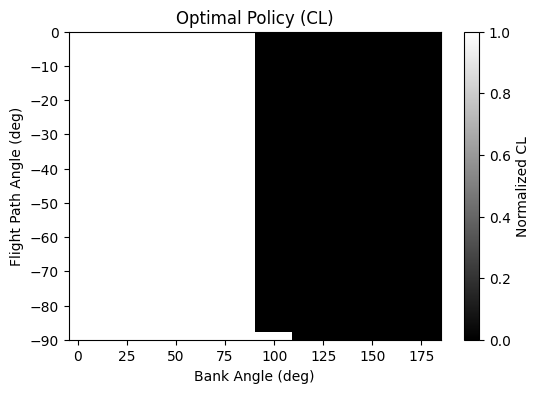

In [ ]:
# Normalize the policy values (0 to 1) for grayscale plotting
vmin, vmax = policy_values.min(), policy_values.max()
norm_values = (policy_values - vmin) / (vmax - vmin + 1e-8)

# Create a mesh for plotting
X, Y = np.meshgrid(bank_angles, flight_path_angles)

# Plot using pcolormesh (grayscale)
fig, ax = plt.subplots(figsize=(6, 4))
c = ax.pcolormesh(X, Y, norm_values, cmap='gray', shading='auto', norm=mcolors.Normalize(vmin=0, vmax=1))

# Labels and title
ax.set_xlabel("Bank Angle (deg)")
ax.set_ylabel("Flight Path Angle (deg)")
ax.set_title("Optimal Policy (CL)")

# Optional: colorbar
plt.colorbar(c, ax=ax, label="Normalized CL")

plt.show()


In [15]:
-192769.51 + -125086.89

-317856.4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_optimal_action

# initial state
state = np.array([np.deg2rad(-60), 1.2, np.deg2rad(30)])
glider.airplane.flight_path_angle = state[0]
glider.airplane.airspeed_norm     = state[1]
glider.airplane.bank_angle        = state[2]

total_height_lost = 0
episode_length    = 0
terminated        = False

time_history = []
height_lost_history = []

while episode_length < 20:
    action = get_optimal_action(state, pi)
    prev_state = state.copy()
    state, reward, terminated, _, _ = glider.step(action)
    state = state[0] 
    total_height_lost += reward
    episode_length += 0.01

    time_history.append(episode_length)  # for plotting!
    height_lost_history.append(total_height_lost)

    #print(f"Action: {np.round(action,3)} | Lost Height: {total_height_lost:.3f} | State: {state} | Terminated: {terminated} | Time: {episode_length:.2f}")
    if terminated:
        break

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_history, height_lost_history, label="Height Lost")
plt.xlabel("Time (s)")
plt.ylabel("Height Lost (m)")
plt.title("Height Lost Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
STALL_AIRSPEED = 27.331231856346
from utils.utils import get_optimal_action
from tqdm import tqdm
with open(glider.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

prom_episode_lenght = 0
dict_result = {}
dict_episode_length = {}
state_spaces = [v for v in pi.states_space if v[0] > -np.pi/2]
for state in tqdm(state_spaces):
    initial_state = state.copy()
    prev_state = state.copy()
    glider.reset()
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    glider.airplane.bank_angle = state[2]
    done = False
    episode_length = 0
    total_reward = 0
    while not done:
        action = get_optimal_action(state, pi)
        prev_state  = state.copy()
        state, reward, done, _, _ = glider.step(action)
        done  = bool(done)
        if done:
            break
        state = state[0]
        # check if our state is in the state space
        index = pi.triangulation.find_simplex(state)
        if not done:
            total_reward -= reward#*STALL_AIRSPEED
        if (index ==-1) or episode_length > 70: 
            done = True
        episode_length += 1
        
    dict_result[tuple(initial_state)] = total_reward
    dict_episode_length[tuple(initial_state)] = episode_length
    prom_episode_lenght += episode_length / len(pi.states_space)
    #print(f"Initial state: {initial_state} - Total reward: {total_reward}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
epsilon = 1*1e-1
#dict_result = dict_episode_length
# Your dictionary with keys as coordinates (x, y) and values as the color intensity (z)
# Extracting the x, y and z values
x = [np.degrees(coord[0]) for coord in dict_result.keys() if 0.05 >= coord[0] >= -np.pi/2 - epsilon and coord[1] > 0.7]
#convert x to grad
y = [coord[1] for coord in dict_result.keys() if 0.05 >= coord[0] >= -np.pi/2 - epsilon and coord[1] > 0.7]
#convert y to Vs
keys_list = list(dict_result.keys())
values_list = list(dict_result.values())
z = [v for e,v in zip(keys_list, values_list) if 0.05 >= e[0] >= -np.pi/2 - epsilon and e[1] > 0.7]

# Creating a 2D scatter plot
cmap = plt.get_cmap('viridis', 2048)
plt.tricontourf(y, x, z, cmap=cmap, levels=18)   # Change 'viridis' to any other colormap you like
plt.colorbar(label='', shrink=0.8,  )  # Add color bar for the z values

# Add labels and a title
plt.ylabel('Flight Path Angle (γ) [deg]')
plt.xlabel('V/Vs')

x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

# Set the minor ticks for the grid, keeping the dense grid with smaller squares
ax = plt.gca()  # Get current axes
ax.set_yticks(np.linspace(x_min, x_max, 60), minor=True)  # 20 minor ticks for grid
ax.set_xticks(np.linspace(y_min, y_max, 60), minor=True)  # 20 minor ticks for grid
# put line x = 1
plt.axvline(x=1, color='r', linestyle='--', linewidth=0.5)
# put line y = 0
#plt.axhline(y=0, color='k', linestyle='--')

# Show the plot
vals = np.round(np.linspace(-90, 0,6))
plt.yticks(vals)  # Only 5 labels on x-axis
plt.xticks(np.linspace(round(y_min), round(y_max), 6))  # Only 5 labels on y-axis
# Enable the minor grid lines
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Habilitar la cuadrícula en las marcas menores
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Guardar la imagen sin borde blanco
plt.savefig('output.png', bbox_inches='tight')

# set size of the plot
plt.gcf().set_size_inches(9, 5)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Your dictionary with keys as coordinates (x, y) and values as the color intensity (z)
# Extracting the x, y and z values
x = [np.degrees(coord[0]) for coord in dict_result.keys() if 5 >= coord[0] >= -np.pi/2 and coord[1] > 0.7]
y = [coord[1] for coord in dict_result.keys() if 5 >= coord[0] >= -np.pi/2 and coord[1] > 0.7]
keys_list = list(dict_result.keys())
values_list = list(dict_result.values())
z = [v for e,v in zip(keys_list, values_list) if 5 >= e[0] >= -np.pi/2 and e[1] > 0.7]

# Create a grid for interpolation
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate the scattered data into the grid
Z = griddata((y, x), z, (Y, X), method='linear')

# Create the scatter plot
cmap = plt.get_cmap('viridis', 2048)
plt.scatter(y, x, c=z, cmap=cmap)

# Add color bar
plt.colorbar(label='', shrink=0.8)
contour_levels = np.linspace(np.min(z), np.max(z), 10)  # 10 levels
contour_levels = contour_levels[contour_levels != 0]    # Remove zero from levels

# Add contour lines on top of the scatter plot
contour = plt.contour(Y, X, Z, levels=contour_levels, colors='black', linewidths=0.75)
plt.clabel(contour, inline=True, fontsize=8)  # Optional: add labels to the contours

# Add labels and a title
plt.ylabel('Flight Path Angle (γ) [deg]')
plt.xlabel('V/Vs')

# Plot vertical line at x=1
plt.axvline(x=1, color='k', linestyle='--')

# Configure the minor ticks and grid
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)
ax = plt.gca()  # Get current axes
ax.set_yticks(np.linspace(x_min, x_max, 60), minor=True)
ax.set_xticks(np.linspace(y_min, y_max, 60), minor=True)
plt.yticks(np.linspace(x_min, x_max, 6))  # Major ticks on y-axis
plt.xticks(np.linspace(y_min, y_max, 4))  # Major ticks on x-axis

# Set size of the plot
plt.gcf().set_size_inches(9, 5)

# Enable the minor grid lines
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.25)

# Habilitar la cuadrícula en las marcas menores
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.25)

# Save the image
plt.savefig('output_with_contours.png', bbox_inches='tight')

# Show the plot
plt.show()


# CartPoleEnv 

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

In [ ]:
# Train cartpole environment:
from classic_control.cartpole import CartPoleEnv
# CartPole environment:
env = CartPoleEnv(sutton_barto_reward=True)
# position thresholds:
x_lim         = 2.4
theta_lim     = 0.418 
# velocity thresholds:
x_dot_lim     = 3.1
theta_dot_lim = 3.1

bins_space = {
    "x_space"         : np.linspace(-x_lim, x_lim, 10,  dtype=np.float32),                     # position space          (0)
    "x_dot_space"     : np.linspace(-x_dot_lim, x_dot_lim, 10,  dtype=np.float32),             # velocity space          (1)
    "theta_space"     : np.linspace(-theta_lim, theta_lim, 10, dtype=np.float32),              # angle space             (2)
    "theta_dot_space" : np.linspace(-theta_dot_lim, theta_dot_lim, 10, dtype=np.float32),      # angular velocity space  (3)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.array([0, 1], dtype=np.int32),
    gamma=0.99,
    theta=1e-3
)

pi.run()

In [ ]:
# Test cartpole environment:

with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi = pickle.load(f)

test_enviroment(CartPoleEnv(sutton_barto_reward=True, render_mode="human"), pi)

## Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min   | Max  | Unit         |
|-----|--------------------------------------|-------|------|--------------|
| 0   | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1   | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

## Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don't accelerate
- 2: Accelerate to the right


In [ ]:
from classic_control.continuous_mountain_car import Continuous_MountainCarEnv

env=Continuous_MountainCarEnv()

bins_space = {
    "x_space":     np.linspace(env.min_position, env.max_position, 100,      dtype=np.float32),    # position space    (0)
    "x_dot_space": np.linspace(-abs(env.max_speed), abs(env.max_speed), 100, dtype=np.float32),    # velocity space    (1)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.linspace(-1.0, +1.0, 9, dtype=np.float32),
    gamma=0.99,
    theta=1e-3,
)
pi.run()

In [ ]:
# Test mountain car environment:
with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

test_enviroment(Continuous_MountainCarEnv(render_mode="human"), pi)